In [1]:
import sys
sys.path.append("../")

import pandas as pd
import os
import numpy as np

from library import regulations
from library import analysis
from library import tables
from library import start
import statsmodels.formula.api as smf

import matplotlib.pyplot as plt


In [2]:
data_path = start.data_path
table_path = start.table_path
data = pd.read_csv(os.path.join(data_path, 'clean', 'master_data_district.csv'),
                  sep=",")
data = data[data.doi == 1]
data.sample(5)

/Users/kylieleblancKylie/anaconda/envs/spacy/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,year,district,distname,distischarter,rating_academic,rating_financial,type,type_description,cntyname,...,pre4,pre3,pre2,pre1,post1,post2,post3,max_school_avescore,min_school_avescore,school_spread
697,697,2012,127904,HAWLEY ISD,N,NaN,NaN,H,RURAL,JONES,...,0,0,0,0,0,0,0,0.235859,-0.328560,0.564419
7060,7060,2017,197902,MIAMI ISD,N,M,Pass,H,RURAL,ROBERTS,...,0,0,0,1,0,0,0,0.719090,0.719090,0.000000
4496,4496,2015,161912,RIESEL ISD,N,M,Pass,H,RURAL,MCLENNAN,...,0,1,0,0,0,0,0,0.243285,0.190843,0.052443
412,412,2012,81905,WORTHAM ISD,N,NaN,NaN,H,RURAL,FREESTONE,...,0,0,0,0,0,0,0,-0.178044,-0.522449,0.344405
1379,1379,2013,30902,CLYDE ISD,N,M,NaN,D,OTHER CENTRAL CITY SUBURBAN,CALLAHAN,...,0,0,0,0,0,0,0,0.033801,-0.577221,0.611021


In [3]:
data_pre = data.loc[data.pre1 == 1]
#data_pre = data_pre.drop_duplicates(subset = 'district')
data_pre = data_pre.rename(columns = {'students_hisp': 'pre_hisp',
                                     'students_ell': 'pre_ell',
                                      'students_white': 'pre_white',
                                      'students_black': 'pre_black',
                                     'students_sped': 'pre_sped',
                                     'avescores': 'pre_avescore',
                                    'students_num': 'pre_num',
                                      'teachers_exp': 'pre_exp',
                                    'teachers_turnover_ratio_d': 'pre_turnover',
                                     'students_teacher_ratio': 'pre_ratio'})
for var in ['pre_hisp', 'pre_ell', 'pre_white', 'pre_black', 
            'pre_sped', 'pre_num', 'pre_turnover', 'pre_avescore']:
    for p in [.25, .5, .75, 1]:
        num = str(int(p * 100))
        newvar = var + num
        if p == .25:
            data_pre[newvar] = np.where(data_pre[var] <= data_pre[var].quantile(p), 1, 0)
        if p > .25:
            lp = p - .25
            data_pre[newvar] = np.where(((data_pre[var] > data_pre[var].quantile(lp)) &
                                         (data_pre[var] <= data_pre[var].quantile(p))), 1, 0)
variables = ['district']
variables = variables + (list(data_pre.filter(regex = ("pre_"))))
data_pre = data_pre[variables]
data_pre = data_pre.merge(data[data.year == 2016][['district', 'type_urban', 'type_suburban', 'type_town', 'type_rural']], 
                          how = 'left', left_on = ['district'], right_on = ['district'])
data_pre = data_pre.rename(columns = {'type_urban': 'pre_urban',
                                      'type_suburban': 'pre_suburban',
                                      'type_town': 'pre_town',
                                      'type_rural': 'pre_rural'})
data_pre['pre_turnover'] = data_pre.pre_turnover / 100
data_pre.sample(5)

,district,pre_num,pre_turnover,pre_black,pre_hisp,pre_white,pre_ell,pre_sped,pre_ratio,pre_avescore,...,pre_turnover75,pre_turnover100,pre_avescore25,pre_avescore50,pre_avescore75,pre_avescore100,pre_urban,pre_suburban,pre_town,pre_rural
109,126911,1765,0.129,0.010765,0.232861,0.705949,0.100283,0.116147,12.155647,-0.114072,...,0,0,0,1,0,0,0,1,0,0
459,138904,100,0.168,0.000000,0.350000,0.590000,0.020000,0.100000,8.403361,0.543157,...,0,0,0,0,1,0,0,0,0,1
401,110905,375,0.141,0.005333,0.392000,0.584000,0.016000,0.074667,11.829653,0.505906,...,0,0,0,0,1,0,0,0,0,1
117,139911,2715,0.114,0.042357,0.082505,0.813628,0.023941,0.137017,11.113385,0.381447,...,0,0,0,0,1,0,0,0,1,0
596,211902,579,0.179,0.006908,0.644214,0.321244,0.141623,0.081174,9.763912,0.077539,...,1,0,0,1,0,0,0,0,0,1


In [4]:
data = data.reset_index().merge(data_pre, left_on = 'district', right_on = 'district', how = 'left')
data = data[data.year == 2018]
data.head(5)

,index,Unnamed: 0,year,district,distname,distischarter,rating_academic,rating_financial,type,type_description,...,pre_turnover75,pre_turnover100,pre_avescore25,pre_avescore50,pre_avescore75,pre_avescore100,pre_urban,pre_suburban,pre_town,pre_rural
4929,7311,7311,2018,1902,CAYUGA ISD,N,B,Pass,H,RURAL,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4930,7312,7312,2018,1903,ELKHART ISD,N,B,Pass,G,NON-METROPOLITAN STABLE,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4931,7313,7313,2018,1904,FRANKSTON ISD,N,B,Pass,H,RURAL,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4932,7314,7314,2018,1906,NECHES ISD,N,B,Pass,H,RURAL,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4933,7315,7315,2018,1907,PALESTINE ISD,N,B,Pass,E,INDEPENDENT TOWN,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [5]:
def create_count_urban_df(data, list_of_regs, dict_of_reg_labels):
    n_col = []
    p_urban = []
    p_suburb = []
    p_town = []
    p_rural = []
    reg_labels = []
    f_p = []

    for reg in list_of_regs:
        n_col.append((len(data[data[reg] == 1])))
        p_urban.append(data[data.type_urban == 1][reg].mean().round(2))
        p_suburb.append(data[data.type_suburban == 1][reg].mean().round(2))
        p_town.append(data[data.type_town == 1][reg].mean().round(2))
        p_rural.append(data[data.type_rural == 1][reg].mean().round(2))
        reg_labels.append(dict_of_reg_labels[reg])
        formula = reg + '~ type_urban + type_suburban + type_town + type_rural - 1'
        df = data.dropna(subset=['type_urban', 'type_suburban', 'type_town', 'type_rural', reg])
        results = smf.ols(formula, data=df).fit()
        f_p.append(results.f_pvalue.round(2))

    df = pd.DataFrame(
            {'Regulation': reg_labels,
             'Count': n_col,
             'Urban': p_urban,
             'Suburban': p_suburb,
             'Town': p_town,
             'Rural': p_rural,
             'F-test p-value': f_p
             })

    return df

In [6]:
def create_count_proportion_df(data, var, list_of_regs, formula):
    n_col = []
    p_25 = []
    p_50 = []
    p_75 = []
    p_100 = []
    reg_labels = []
    f_p = []

    for reg in list_of_regs:
        n_col.append((len(data[data[reg] == 1])))
        for p_list, p in zip([p_25, p_50, p_75, p_100], [.25, .5, .75, 1]):
            num = str(int(p * 100))
            p_var = var + num            
            p_list.append(data[data[p_var] == 1][reg].mean().round(2))
        reg_labels.append(regulations.labels[reg])
        df = data.dropna(subset=[var, reg])
        full_formula = reg + formula
        results = smf.ols(full_formula, data=df).fit()
        f_p.append(results.f_pvalue.round(2))

    df = pd.DataFrame(
            {'Regulation': reg_labels,
             'Count': n_col,
             'Q1': p_25,
              'Q2': p_50,
             'Q3': p_75,
             'Q4': p_100,
             'F-test p-value': f_p
             })
    return df

# Urbanicity

In [7]:
len(data[data.type_rural == 1])

362

In [8]:
columns = ['Count', 'Urban', 'Suburban', 'Town', 'Rural', 'F-test p-value']

In [9]:
schedules_df = create_count_urban_df(data, regulations.schedules, regulations.labels)
tables.df_to_excel(file = table_path + 'desc_exemptionsXurbanicity.xlsx', df = schedules_df,
                  df_columns = columns, start_row = 5, start_col = 3)
schedules_df


/Users/kylieleblancKylie/anaconda/envs/spacy/lib/python3.7/site-packages/statsmodels/compat/pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


,Regulation,Count,Urban,Suburban,Town,Rural,F-test p-value
0,25.0811 - Minimum First Day of Instruction,798,0.95,0.96,0.98,0.98,0.31
1,25.081 - Minimum Minutes of Operation,356,0.49,0.40,0.37,0.48,0.05
2,25.0812 - Minimum Last Day of Instruction,231,0.24,0.25,0.27,0.31,0.33
3,25.082 - Pledge of Allegiance and Minute of Si...,208,0.24,0.21,0.27,0.27,0.44


In [10]:
class_size_df = create_count_urban_df(data, regulations.class_size, regulations.labels)
tables.df_to_excel(file = table_path + 'desc_exemptionsXurbanicity.xlsx', df = class_size_df,
                  df_columns = columns, start_row = 10, start_col = 3)
class_size_df

,Regulation,Count,Urban,Suburban,Town,Rural,F-test p-value
0,25.112 - Class Size Maximum,363,0.38,0.43,0.47,0.43,0.62
1,25.113 - Notice of Class Size,299,0.35,0.35,0.40,0.35,0.60
2,25.111 - Maximum Student Teacher Ratio,127,0.19,0.17,0.16,0.14,0.83


In [11]:
certification_df = create_count_urban_df(data, regulations.certification, regulations.labels)
tables.df_to_excel(file = table_path + 'desc_exemptionsXurbanicity.xlsx', df = certification_df,
                  df_columns = columns, start_row = 14, start_col = 3)
certification_df

,Regulation,Count,Urban,Suburban,Town,Rural,F-test p-value
0,21.003 - Teacher Certification Required,714,0.73,0.81,0.88,0.91,0.00
1,21.053 - Presentation of Teacher Certificates,240,0.30,0.25,0.31,0.30,0.50
2,21.057 - Notice of Uncertified Teacher,271,0.30,0.26,0.36,0.36,0.09


In [12]:
contracts_df = create_count_urban_df(data, regulations.contracts, regulations.labels)
tables.df_to_excel(file = table_path + 'desc_exemptionsXurbanicity.xlsx', df = contracts_df,
                  df_columns = columns, start_row = 18, start_col = 3)
contracts_df

,Regulation,Count,Urban,Suburban,Town,Rural,F-test p-value
0,21.102 - Maximum Probationary Contract Length,419,0.16,0.42,0.58,0.55,0.00
1,21.401 - Minimum Service Days Required for Tea...,290,0.03,0.13,0.29,0.55,0.00
2,21.352 - Teacher Evaluation,166,0.22,0.22,0.21,0.19,0.90
3,21.354 - Administrator Evaluation,46,0.11,0.06,0.04,0.06,0.41


In [13]:
behavior_df = create_count_urban_df(data, regulations.behavior, regulations.labels)
tables.df_to_excel(file = table_path + 'desc_exemptionsXurbanicity.xlsx', df = behavior_df,
                  df_columns = columns, start_row = 23, start_col = 3)
behavior_df

,Regulation,Count,Urban,Suburban,Town,Rural,F-test p-value
0,25.092 - Minimum Attendance for Class Credit,214,0.51,0.35,0.27,0.18,0.0
1,37.0012 - Designation of Campus Behavior Coord...,178,0.35,0.28,0.28,0.13,0.0
2,25.036 - Transfers,178,0.03,0.07,0.23,0.31,0.0


# Teacher Turnover

In [15]:
columns = ['Count', 'Q1', 'Q2', 'Q3', 'Q4', 'F-test p-value']
schedules_df = create_count_proportion_df(data, 'pre_turnover', regulations.schedules, 
                                          ' ~ pre_turnover25 + pre_turnover50 + pre_turnover75 + pre_turnover100')
tables.df_to_excel(file = table_path + 'desc_exemptionsXturnover.xlsx', df = schedules_df,
                  df_columns = columns, start_row = 5, start_col = 3)

class_size_df = create_count_proportion_df(data, 'pre_turnover',  regulations.class_size, 
                                            ' ~ pre_turnover25 + pre_turnover50 + pre_turnover75 + pre_turnover100')
tables.df_to_excel(file = table_path + 'desc_exemptionsXturnover.xlsx', df = class_size_df,
                  df_columns = columns, start_row = 10, start_col = 3)

certification_df = create_count_proportion_df(data,  'pre_turnover', regulations.certification, 
                                              ' ~ pre_turnover25 + pre_turnover50 + pre_turnover75 + pre_turnover100')
tables.df_to_excel(file = table_path + 'desc_exemptionsXturnover.xlsx', df = certification_df,
                  df_columns = columns, start_row = 14, start_col = 3)

contracts_df = create_count_proportion_df(data,  'pre_turnover', regulations.contracts, 
                                          ' ~ pre_turnover25 + pre_turnover50 + pre_turnover75 + pre_turnover100')
tables.df_to_excel(file = table_path + 'desc_exemptionsXturnover.xlsx', df = contracts_df,
                  df_columns = columns, start_row = 18, start_col = 3)

behavior_df = create_count_proportion_df(data,  'pre_turnover', regulations.behavior, 
                                         ' ~ pre_turnover25 + pre_turnover50 + pre_turnover75 + pre_turnover100')
tables.df_to_excel(file = table_path + 'desc_exemptionsXturnover.xlsx', df = behavior_df,
                  df_columns = columns, start_row = 23, start_col = 3)

# Prior Achievement

In [17]:
columns = ['Count', 'Q1', 'Q2', 'Q3', 'Q4', 'F-test p-value']
formula = ' ~ pre_avescore25 + pre_avescore50 + pre_avescore75 + pre_avescore100'
schedules_df = create_count_proportion_df(data, 'pre_avescore', regulations.schedules, formula)
tables.df_to_excel(file = table_path + 'desc_exemptionsXachievement.xlsx', df = schedules_df,
                  df_columns = columns, start_row = 5, start_col = 3)

class_size_df = create_count_proportion_df(data, 'pre_avescore',  regulations.class_size, formula)
tables.df_to_excel(file = table_path + 'desc_exemptionsXachievement.xlsx', df = class_size_df,
                  df_columns = columns, start_row = 10, start_col = 3)

certification_df = create_count_proportion_df(data,  'pre_avescore', regulations.certification, formula)
tables.df_to_excel(file = table_path + 'desc_exemptionsXachievement.xlsx', df = certification_df,
                  df_columns = columns, start_row = 14, start_col = 3)

contracts_df = create_count_proportion_df(data,  'pre_avescore', regulations.contracts, formula)
tables.df_to_excel(file = table_path + 'desc_exemptionsXachievement.xlsx', df = contracts_df,
                  df_columns = columns, start_row = 18, start_col = 3)

behavior_df = create_count_proportion_df(data,  'pre_avescore', regulations.behavior, formula)
tables.df_to_excel(file = table_path + 'desc_exemptionsXachievement.xlsx', df = behavior_df,
                  df_columns = columns, start_row = 23, start_col = 3)

# Percent Hispanic

In [19]:
columns = ['Count', 'Q1', 'Q2', 'Q3', 'Q4', 'F-test p-value']
formula = ' ~ pre_hisp25 + pre_hisp50 + pre_hisp75 + pre_hisp100'
schedules_df = create_count_proportion_df(data, 'pre_hisp', regulations.schedules, formula)
tables.df_to_excel(file = table_path + 'desc_exemptionsXhispanic.xlsx', df = schedules_df,
                  df_columns = columns, start_row = 5, start_col = 3)

class_size_df = create_count_proportion_df(data, 'pre_hisp',  regulations.class_size, formula)
tables.df_to_excel(file = table_path + 'desc_exemptionsXhispanic.xlsx', df = class_size_df,
                  df_columns = columns, start_row = 10, start_col = 3)

certification_df = create_count_proportion_df(data, 'pre_hisp', regulations.certification, formula)
tables.df_to_excel(file = table_path + 'desc_exemptionsXhispanic.xlsx', df = certification_df,
                  df_columns = columns, start_row = 14, start_col = 3)

contracts_df = create_count_proportion_df(data, 'pre_hisp', regulations.contracts, formula)
tables.df_to_excel(file = table_path + 'desc_exemptionsXhispanic.xlsx', df = contracts_df,
                  df_columns = columns, start_row = 18, start_col = 3)

behavior_df = create_count_proportion_df(data, 'pre_hisp', regulations.behavior, formula)
tables.df_to_excel(file = table_path + 'desc_exemptionsXhispanic.xlsx', df = behavior_df,
                  df_columns = columns, start_row = 23, start_col = 3)

# Perfect Black

In [20]:
columns = ['Count', 'Q1', 'Q2', 'Q3', 'Q4', 'F-test p-value']
formula = ' ~ pre_black25 + pre_black50 + pre_black75 + pre_hisp100'
schedules_df = create_count_proportion_df(data, 'pre_hisp', regulations.schedules, formula)
tables.df_to_excel(file = table_path + 'desc_exemptionsXblack.xlsx', df = schedules_df,
                  df_columns = columns, start_row = 5, start_col = 3)

class_size_df = create_count_proportion_df(data, 'pre_hisp',  regulations.class_size, formula)
tables.df_to_excel(file = table_path + 'desc_exemptionsXblack.xlsx', df = class_size_df,
                  df_columns = columns, start_row = 10, start_col = 3)

certification_df = create_count_proportion_df(data,  'pre_hisp', regulations.certification, formula)
tables.df_to_excel(file = table_path + 'desc_exemptionsXblack.xlsx', df = certification_df,
                  df_columns = columns, start_row = 14, start_col = 3)

contracts_df = create_count_proportion_df(data,  'pre_hisp', regulations.contracts, formula)
tables.df_to_excel(file = table_path + 'desc_exemptionsXblack.xlsx', df = contracts_df,
                  df_columns = columns, start_row = 18, start_col = 3)

behavior_df = create_count_proportion_df(data,  'pre_hisp', regulations.behavior, formula)
tables.df_to_excel(file = table_path + 'desc_exemptionsXblack.xlsx', df = behavior_df,
                  df_columns = columns, start_row = 23, start_col = 3)

# Scatter Plots

In [21]:
bins = [0, .05, .10, .15, .20, .25, .30, .35, .40, .45, .50, .55, .60, .65, .70, .75, .80, .85, .90, .95, 1]
labels = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]
data['bins']  = pd.cut(data['students_hisp'], bins, labels = labels)

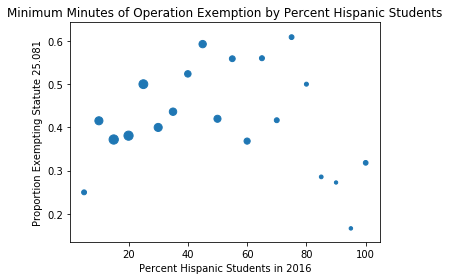

In [22]:
df = data[['bins', 'reg25_081']].groupby('bins')['reg25_081'].describe().reset_index().rename(columns = {'mean': 'p'})
plt.scatter(df.bins, df.p, s = df['count'])

plt.ylabel('Proportion Exempting Statute 25.081')
plt.xlabel('Percent Hispanic Students in 2016')
plt.title('Minimum Minutes of Operation Exemption by Percent Hispanic Students')

pws = (pd.cut(df['count'], bins=4, retbins=True)[1]).round(0)
for pw in pws:
    plt.scatter([], [], s=df['count'], c="k",label=str(pw))

h, l = plt.gca().get_legend_handles_labels()
#plt.legend(h[5:], l[5:], labelspacing=1.2, title="Count", borderpad=1, 
#            frameon=True, framealpha=0.9, loc=4, numpoints=1)

plt.gca()

plt.tight_layout()
plt.savefig(table_path + 'scatter_dem_minutes.png', dpi = 800)

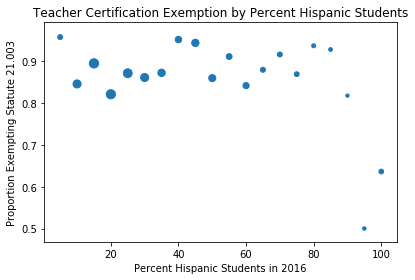

In [23]:
df = data[['bins', 'reg21_003']].groupby('bins')['reg21_003'].describe().reset_index().rename(columns = {'mean': 'p'})
plt.scatter(df.bins, df.p, s = df['count'])

plt.ylabel('Proportion Exempting Statute 21.003')
plt.xlabel('Percent Hispanic Students in 2016')
plt.title('Teacher Certification Exemption by Percent Hispanic Students')

pws = (pd.cut(df['count'], bins=4, retbins=True)[1]).round(0)
for pw in pws:
    plt.scatter([], [], s=df['count'], c="k",label=str(pw))

#h, l = plt.gca().get_legend_handles_labels()
#plt.legend(h[5:], l[5:], labelspacing=1.2, title="Count", borderpad=1, 
#            frameon=True, framealpha=0.9, loc=4, numpoints=1)

plt.gca()

plt.tight_layout()
plt.savefig(table_path + 'scatter_dem_certification.png', dpi = 800)
plt.show()


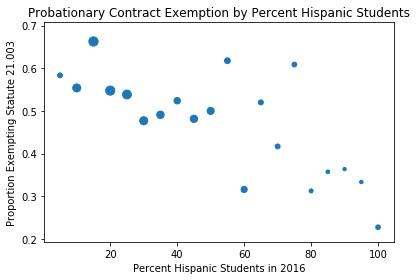

In [24]:
df = data[['bins', 'reg21_102']].groupby('bins')['reg21_102'].describe().reset_index().rename(columns = {'mean': 'p'})
plt.scatter(df.bins, df.p, s = df['count'])

plt.ylabel('Proportion Exempting Statute 21.003')
plt.xlabel('Percent Hispanic Students in 2016')
plt.title('Probationary Contract Exemption by Percent Hispanic Students')

pws = (pd.cut(df['count'], bins=4, retbins=True)[1]).round(0)
for pw in pws:
    plt.scatter([], [], s=df['count'], c="k",label=str(pw))

#h, l = plt.gca().get_legend_handles_labels()
#plt.legend(h[5:], l[5:], labelspacing=1.2, title="Count", borderpad=1, 
#            frameon=True, framealpha=0.9, loc=4, numpoints=1)

plt.gca()

plt.tight_layout()
plt.savefig(table_path + 'scatter_dem_probation.png', dpi = 800)
plt.show()

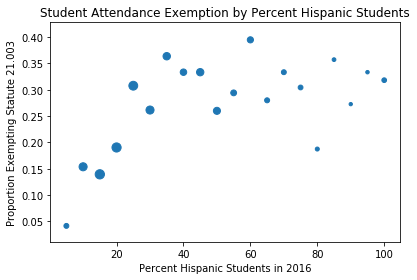

In [25]:
df = data[['bins', 'reg25_092']].groupby('bins')['reg25_092'].describe().reset_index().rename(columns = {'mean': 'p'})
plt.scatter(df.bins, df.p, s = df['count'])

plt.ylabel('Proportion Exempting Statute 21.003')
plt.xlabel('Percent Hispanic Students in 2016')
plt.title('Student Attendance Exemption by Percent Hispanic Students')

pws = (pd.cut(df['count'], bins=4, retbins=True)[1]).round(0)
for pw in pws:
    plt.scatter([], [], s=df['count'], c="k",label=str(pw))

#h, l = plt.gca().get_legend_handles_labels()
#plt.legend(h[5:], l[5:], labelspacing=1.2, title="Count", borderpad=1, 
#            frameon=True, framealpha=0.9, loc=4, numpoints=1)

plt.gca()

plt.tight_layout()
plt.savefig(table_path + 'scatter_dem_attendance.png', dpi = 800)
plt.show()